## Minimum code for plotting dipeptide effects in WT cells

In [1]:
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rasilabRtemplates))
suppressPackageStartupMessages(library(boot))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(plotrix))
suppressPackageStartupMessages(library(ggh4x))

insert_reads_cutoff <- 500
n_barcodes_cutoff <- 4
barcode_reads_cutoff <- 10 
set.seed(1234)

In [2]:
theme <- theme(
        title = element_text(margin = margin(t=0, r=2, b=2, l=2), size=8),
        axis.title.x = element_text(margin = margin(t=2, r=2, b=0, l=2), size=8),
        axis.title.y = element_text(margin = margin(t=2, r=2, b=2, l=0), size=8),
        text = element_text(size = 8),
        legend.text=element_text(size=8),
        axis.line.x=element_line(linewidth=0.2),
        axis.line.y=element_line(linewidth=0.2),
        axis.ticks.y =  element_line(linewidth=0.2),
        axis.ticks.x = element_line(linewidth=0.2),
        axis.text.x = element_text(size=8),
        axis.text.y = element_text(size=8)
        )

In [3]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

if (!file.exists('../tables')){
    dir.create('../tables')
}

### Load sample annotations and barcode counts

In [4]:
sample_annotations = read_csv("../annotations/sample_annotations.csv", comment='#')
sample_annotations

Rows: 2 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): owner, sample_type, sample_name, plasmid, library_type, illumina_s...
dbl  (3): barcode_read, barcode_start, barcode_length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


owner,sample_type,sample_name,plasmid,library_type,illumina_sample_id,sample_id,barcode_read,barcode_start,barcode_length,linkage_ref,r1_file,r2_file,s3,shared
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
kc,dicodon_yeast,wt_gdna,pHPSC1142,grna,51lib2,51lib2,1,1,24,yeast_cyto_linkage,kc_51lib2_S13_R1_001,kc_51lib2_S13_R2_001,fh-pi-subramaniam-a-eco/data/kchen/illumina/20220328_exp51_wt_8xdicodon/,/shared/ngs/illumina/subramaniam_lab/220328_VH00319_178_AAAYF3FM5/Unaligned/Project_subramaniam_lab/
kc,dicodon_yeast,wt_mrna,pHPSC1142,mrna,51lib1,51lib1,1,1,24,yeast_cyto_linkage,kc_51lib1_S12_R1_001,kc_51lib1_S12_R2_001,fh-pi-subramaniam-a-eco/data/kchen/illumina/20220328_exp51_wt_8xdicodon/,/shared/ngs/illumina/subramaniam_lab/220328_VH00319_178_AAAYF3FM5/Unaligned/Project_subramaniam_lab/


In [5]:
insert_annotations = read_csv("../../8xdicodon_linkage/annotations/dicodon_yeast.csv") %>%
    mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>%
    drop_na(dicodon) %>% # drops the inserts that aren't dicodons in this case
    mutate(diaa = as.character(translate(DNAStringSet(dicodon), no.init.codon = T))) %>%
    mutate(codon1 = substr(dicodon, 1, 3), codon2 = substr(dicodon, 4, 6),
         aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
    select(-insert) %>%
    print()

Rows: 6000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 4,096 × 7
   insert_num dicodon diaa  codon1 codon2 aa1   aa2  
        <dbl> <chr>   <chr> <chr>  <chr>  <chr> <chr>
 1          0 AAAAAA  KK    AAA    AAA    K     K    
 2          1 AAAAAC  KN    AAA    AAC    K     N    
 3          2 AAAAAG  KK    AAA    AAG    K     K    
 4          3 AAAAAT  KN    AAA    AAT    K     N    
 5          4 AAAACA  KT    AAA    ACA    K     T    
 6          5 AAAACC  KT    AAA    ACC    K     T    
 7          6 AAAACG  KT    AAA    ACG    K     T    
 8          7 AAAACT  KT    AAA    ACT    K     T    
 9          8 AAAAGA  KR    AAA    AGA    K     R    
10          9 AAAAGC  KS    AAA    AGC    K     S    
# … with 4,086 more rows


In [6]:
barcode_counts <- list.files("../data/linked_barcode_counts/", pattern = ".csv$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_csv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(barcode_count = as.numeric(barcode_count)) %>%
  mutate(linkage_count = as.numeric(linkage_count))

Rows: 197785 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 172594 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(counts)`”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


### Apply minor cutoffs & bootstrap sample LFCs by dipeptide
- reads per barcode, barcodes per dicodon insert
- sample all barcodes for a dipeptide

In [7]:
wt_dicodon <- barcode_counts %>%
    filter(barcode_count >= barcode_reads_cutoff) %>%
    mutate(sample_type = str_extract(sample_name, '[^_]+$')) %>%
    mutate(sample_name = str_extract(sample_name, '[^_]+')) %>%
    filter(sample_name == 'wt') %>%
    group_by(sample_type, insert_num) %>%
    mutate(n_barcodes = n()) %>%
    filter(n_barcodes >= n_barcodes_cutoff) %>% # filter out inserts that don't reach barcode rep cutoff while maintaining data as individual barcodes
    ungroup() %>%
    inner_join(insert_annotations, by='insert_num') %>%
    select(-n_barcodes, -barcode, -aa1, -aa2, -codon1, -codon2) %>%
    pivot_wider(names_from='sample_type', values_from=c(barcode_count)) %>%
    drop_na()

In [8]:
insert_annotations_1 = read_csv("../../8xdicodon_linkage/annotations/dicodon_yeast.csv") %>%
    mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>%
    mutate(aa = as.character(translate(DNAStringSet(insert), no.init.codon = T)))

Rows: 6000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Highlight dipeptides that are >= 2 standard deviations from the median and cutoff by std.error

In [9]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$gdna))
}
set.seed <- 1234

wt_diaa_bootstrap_diaa <- wt_dicodon %>%
  filter(sample_name == 'wt') %>%
  group_by(diaa) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  mutate(lfc_se = map_dbl(lfc_boot, std.error)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(strain = 'wt')

In [10]:
sd_q3 <- quantile(wt_diaa_bootstrap_diaa$lfc_sd)[4][[1]]
sd_iqr <- IQR(wt_diaa_bootstrap_diaa$lfc_sd)
sd_outlier <- sd_q3+(1.5 * sd_iqr) 
se_q3 <- quantile(wt_diaa_bootstrap_diaa$lfc_se)[4][[1]]
se_iqr <- IQR(wt_diaa_bootstrap_diaa$lfc_se)
se_outlier <- se_q3+(1.5 * se_iqr) + 0.005 # relax filter a bit

In [11]:
two_sds_from_med <- wt_diaa_bootstrap_diaa %>%
    filter(lfc_se <= se_outlier) %>%
    dplyr::pull(lfc_med) %>%
    sd() * 2

In [12]:
diaa_boot_med <- wt_diaa_bootstrap_diaa %>% # median of the full bootstrapped library
  dplyr::pull(lfc) %>%
  median()

In [13]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$gdna))
}

set.seed(1234)
wt_bootstrap_dicodon <- wt_dicodon %>%
  group_by(dicodon) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  mutate(lfc_se = map_dbl(lfc_boot, std.error)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  inner_join(insert_annotations, by = "dicodon") %>%
  mutate(strain = 'wt')

In [14]:
select_diaa <- wt_diaa_bootstrap_diaa %>%
    filter(lfc_se <= se_outlier) %>%
    mutate(sds_from_med = case_when(
                            lfc_med >= two_sds_from_med ~ '>=2',
                            lfc_med <= -two_sds_from_med ~ '<=2',
                            TRUE ~ 'within_two_sds')) %>%
    filter(sds_from_med == '<=2') %>%
    arrange(lfc_med) %>%
    dplyr::pull(diaa)

select_dicodons <- wt_dicodon %>%
    filter(diaa %in% select_diaa) %>%
    group_by(dicodon, diaa) %>%
    summarize(n(), .groups='drop') %>%
    dplyr::pull(dicodon)

frameshifts_1 <- wt_bootstrap_dicodon %>%
    filter(dicodon %in% select_dicodons) %>%
    mutate(frameshift = str_c(str_sub(dicodon, 2,6), str_sub(dicodon, 1,1))) %>%
    dplyr::pull(frameshift)

frameshifts_2 <- wt_bootstrap_dicodon %>%
    filter(dicodon %in% select_dicodons) %>%
    mutate(frameshift = str_c(str_sub(dicodon, 3,6), str_sub(dicodon, 1,2))) %>%
    dplyr::pull(frameshift)

In [15]:
wt_dicodon_counts_frame_1 <- wt_dicodon %>%
  filter(sample_name == 'wt') %>%
  filter(dicodon %in% frameshifts_1) %>% 
  filter(!(diaa %in% select_diaa)) %>%
  mutate(Frame='Frameshifted') %>%
  mutate(match_dicodon = str_c(str_sub(dicodon, 6,6), str_sub(dicodon, 1,5))) %>%
  dplyr::rename(frameshifted = dicodon)

wt_dicodon_counts_frame_2 <- wt_dicodon %>%
  filter(sample_name == 'wt') %>%
  filter(dicodon %in% frameshifts_2) %>% 
  filter(!(diaa %in% select_diaa)) %>%
  mutate(Frame='Frameshifted') %>%
  mutate(match_dicodon = str_c(str_sub(dicodon, 5,6), str_sub(dicodon, 1,4))) %>%
  dplyr::rename(frameshifted = dicodon)

wt_dicodon_counts_frameshifted <- bind_rows(wt_dicodon_counts_frame_1, wt_dicodon_counts_frame_2) %>%
  select(frameshifted, diaa, mrna, gdna, Frame, match_dicodon)

In [16]:
wt_dicodon_counts_in_frame <- wt_dicodon %>%
  filter(sample_name == 'wt') %>%
  filter(diaa %in% select_diaa) %>%
  mutate(Frame='In-frame') %>%
  mutate(frameshifted = dicodon) %>%
  dplyr::rename(match_dicodon = dicodon) %>%
  select(frameshifted, diaa, mrna, gdna, Frame, match_dicodon)

wt_dicodon_counts_frames <- bind_rows(wt_dicodon_counts_in_frame, wt_dicodon_counts_frameshifted) %>%
    mutate(match_diaa = as.character(translate(DNAStringSet(match_dicodon), no.init.codon = T)))

In [17]:
set.seed(1234)
select_diaa_frame_boot <- wt_dicodon_counts_frames %>%
    group_by(match_diaa, Frame) %>%
    nest() %>%
    mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
    select(-data) %>%
    mutate(lfc = map_dbl(lfc_boot, mean)) %>%
    mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
    mutate(var = lfc_sd**2) %>%
    select(-lfc_boot) %>%
    ungroup() %>%
    mutate(lfc_med = lfc - diaa_boot_med) %>%
    filter(!str_detect(match_diaa, '\\*'))

In [19]:
select_diaa_frame_boot %>%
    filter(match_diaa != 'YK') %>% # YK produces variable effects in the other datasets 
    write_csv("../tables/destabilized_wt.csv")

## Plot dipeptide heat map

In [21]:
diaa_lfc_burke2022 <- barcode_counts %>% 
  group_by(insert_num, sample_name) %>%
  summarize(count = sum(barcode_count), n_barcodes = dplyr::n(), .groups='drop') %>%
  inner_join(insert_annotations, by = "insert_num") %>%
  group_by(diaa, aa1, aa2, sample_name) %>%
  mutate(count = sum(count), n_barcodes = sum(n_barcodes)) %>%
  ungroup() %>%
  group_by(diaa, aa1, aa2) %>%
  ungroup() %>% 
  pivot_wider(names_from = sample_name, values_from = c("count", "n_barcodes")) %>%
  mutate(lfc = log2(count_wt_mrna) - log2(count_wt_gdna)) %>% 
  group_by(diaa, aa1, aa2) %>%
  slice(1) %>% 
  ungroup() %>%
  drop_na() %>% 
  mutate(lfc_med = lfc - median(lfc))

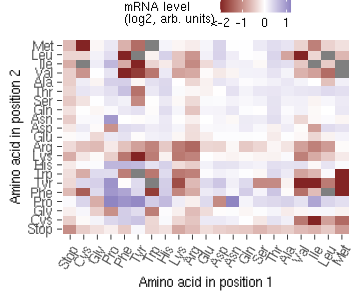

In [22]:
options(repr.plot.width=3, repr.plot.height=2.5)

AMINO_ACID_CODE["*"] = "Stop"
aa_reorder_list <- c("Met", "Leu", "Ile", "Val", "Ala", "Thr", "Ser", "Gln", "Asn", "Asp", "Glu", "Arg", "Lys", "His", "Trp", "Tyr", "Phe", "Pro", "Gly", "Cys", "Stop")

diaa_lfc_burke2022 %>% 
  mutate(aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
  filter(diaa != 'spikein') %>%
  complete(aa1, aa2) %>%
  mutate(aa1 = AMINO_ACID_CODE[aa1], aa2 = AMINO_ACID_CODE[aa2]) %>% 
  mutate(scaled_lfc = case_when(
    lfc_med < -2 ~ -2,
    lfc_med > 2  ~ 2,
    T ~ lfc_med)) %>%
  ggplot(aes(x = aa1, y = aa2, fill = scaled_lfc)) +
  geom_tile() +
  scale_fill_gradient2(labels = rev(c('1', '0', '-1', '<-2'))) +
  scale_x_discrete(limits = rev(aa_reorder_list)) +
  scale_y_discrete(limits = rev(aa_reorder_list)) +
  theme +
  theme(axis.text.x = element_text(angle = 60, hjust = 1),
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.x = element_line(size=0.2),
        axis.ticks.y = element_line(size=0.2),
        legend.key.height = unit(3, 'mm'),
        legend.key.width = unit(3, 'mm'),
        legend.text = element_text(size=7),
        legend.title = element_text(size=7),
        legend.box.margin=margin(-13,-10,-12,-10),
        legend.position='top',
        ) +
  labs(fill = "mRNA level\n(log2, arb. units)", x = "Amino acid in position 1", y = "Amino acid in position 2")

ggsave("../figures/fig2_wt_med_norm_diaa_heatmap_scaled.pdf", width=3.8, height=3.6, units='in')

## Plot dicodon heat map

In [23]:
wt_dicodon_nocutoffs <- barcode_counts %>%
    mutate(sample_type = str_extract(sample_name, '[^_]+$')) %>%
    mutate(sample_name = str_extract(sample_name, '[^_]+')) %>%
    filter(sample_name == 'wt') %>%
    inner_join(insert_annotations, by='insert_num') %>%
    select(-barcode, -aa1, -aa2, -codon1, -codon2) %>%
    pivot_wider(names_from='sample_type', values_from=c(barcode_count)) %>%
    drop_na()

In [24]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$gdna))
}
set.seed(1234)
wt_bootstrap_dicodon_nocutoffs <- wt_dicodon_nocutoffs %>%
  group_by(dicodon) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  inner_join(insert_annotations, by = "dicodon") %>%
  mutate(strain = 'wt')

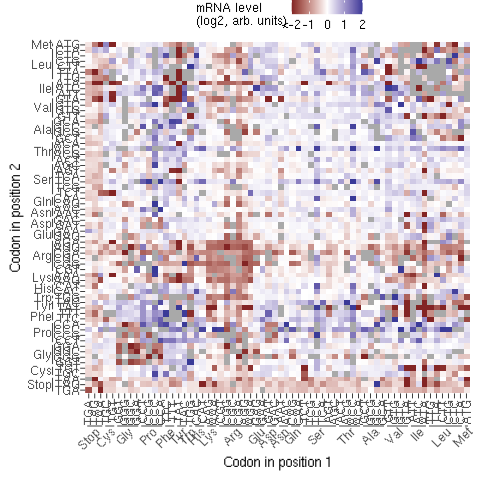

In [25]:
options(repr.plot.width=4, repr.plot.height=4)

codon_reorder_list <- c('ATG,Met','CTA,Leu','CTC,Leu','CTG,Leu','CTT,Leu','TTA,Leu','TTG,Leu','ATA,Ile','ATC,Ile','ATT,Ile','GTA,Val','GTC,Val','GTG,Val','GTT,Val','GCA,Ala','GCC,Ala','GCG,Ala','GCT,Ala','ACA,Thr','ACC,Thr','ACG,Thr','ACT,Thr','AGC,Ser','AGT,Ser','TCA,Ser','TCC,Ser','TCG,Ser','TCT,Ser','CAA,Gln','CAG,Gln','AAC,Asn','AAT,Asn','GAC,Asp','GAT,Asp','GAA,Glu','GAG,Glu','AGA,Arg','AGG,Arg','CGA,Arg','CGC,Arg','CGG,Arg','CGT,Arg','AAA,Lys','AAG,Lys','CAT,His','CAC,His','TGG,Trp','TAC,Tyr','TAT,Tyr','TTT,Phe','TTC,Phe','CCA,Pro','CCC,Pro','CCG,Pro','CCT,Pro','GGA,Gly','GGC,Gly','GGG,Gly','GGT,Gly','TGT,Cys','TGC,Cys','TAA,Stop','TAG,Stop','TGA,Stop')
aa_order <- c('Arg', 'Stop', 'Trp', 'Lys', 'Gly', 'Cys', 'Val', 'Glu', 'Gln', 'Asp', 'Ser', 'Met', 'Ala', 'Leu', 'Ile', 'Asn', 'Tyr', 'His', 'Thr', 'Phe', 'Pro')

wt_bootstrap_dicodon_nocutoffs %>% 
  select(strain, codon1, codon2, lfc, lfc_sd, lfc_med) %>% 
  complete(strain, codon1, codon2) %>%
  mutate(codon1 = factor(str_c(codon1, ',', AMINO_ACID_CODE[GENETIC_CODE[codon1]]), levels=rev(codon_reorder_list))) %>% 
  mutate(codon2 = factor(str_c(codon2, ',', AMINO_ACID_CODE[GENETIC_CODE[codon2]]), levels=rev(codon_reorder_list))) %>% 
  mutate(scaled_lfc = ifelse(lfc_med >= -2 & lfc_med <= 2, lfc_med, ifelse(lfc_med > 2, 2, ifelse(lfc_med < -2, -2, NA)))) %>%
  ggplot(aes(x = codon1, y = codon2, fill = scaled_lfc)) +
  geom_tile() +
  scale_fill_gradient2(na.value='dark grey', labels = rev(c('2', '1', '0', '-1', '<-2'))) +
  scale_x_discrete(guide = guide_axis_nested(delim = ",")) +
  scale_y_discrete(guide = guide_axis_nested(delim = ",")) +
  theme +
  theme(axis.text.x = element_text(angle = 90, vjust=0.5, margin = margin(r = 0), size=7),
        axis.text.y = element_text(margin = margin(r = 0), size=7),
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        legend.key.height = unit(3, 'mm'),
        legend.key.width = unit(3, 'mm'),
        legend.text = element_text(size=7),
        legend.title = element_text(size=7),
        legend.box.margin=margin(-12,-12,-12,-12),
        legend.position='top',
        legend.justification='center',
        ggh4x.axis.nestline = element_line(linewidth = 0.2),
        ggh4x.axis.nesttext.x = element_text(angle = 45, hjust=1, vjust=1),
        ) +
  guides(fill = guide_colourbar(title.position="left", title.justification='left')) +
  labs(fill = "mRNA level\n(log2, arb. units)", x = "Codon in position 1", y = "Codon in position 2")

ggsave("../figures/fig2_bootstrap_dicodon_heatmap_scaled_no_cutoffs.pdf", width=6.7, height=6.4, units='in')

## Plot frame 0 vs frame 3 correlation for dicodons

In [26]:
insert_reads_cutoff <- 500
n_barcodes_cutoff <- 2
barcode_reads_cutoff <- 10
AMINO_ACID_CODE["*"] = "*"

dicodon_lfc_51 <- barcode_counts %>% 
  left_join(select(sample_annotations, c(sample_id, sample_name)), by = "sample_name") %>%
  drop_na(barcode_count) %>%
  select(-sample_id) %>%
  filter(barcode_count >= barcode_reads_cutoff) %>%
  group_by(insert_num, sample_name) %>%
  summarize(count = sum(barcode_count), n_barcodes = dplyr::n(), .groups='drop') %>%
  ungroup() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  group_by(dicodon, diaa, aa1, aa2, sample_name) %>%
  summarize(count = sum(count), n_barcodes = sum(n_barcodes), .groups='drop') %>%
  ungroup() %>%
  pivot_wider(names_from = sample_name, values_from = c("count", "n_barcodes")) %>%
  filter((count_wt_gdna >= insert_reads_cutoff) & (count_wt_mrna >= insert_reads_cutoff)) %>%
  filter((n_barcodes_wt_gdna >= n_barcodes_cutoff) & (n_barcodes_wt_mrna >= n_barcodes_cutoff)) %>%
  mutate(lfc = log2(count_wt_mrna) - log2(count_wt_gdna)) %>%
  drop_na(lfc) %>%
  mutate(lfc = lfc - median(lfc)) %>%
  arrange(lfc)

In [27]:
plot_data <- dicodon_lfc_51 %>% 
  crossing(frame = c("frame" = seq(0,5))) %>%
  select(-lfc, -diaa, -aa1, -aa2) %>%
  mutate(dicodon = substr(paste0(dicodon, dicodon), frame + 1, 6 + frame)) %>%
  group_by(dicodon, frame) %>%
  summarize_all(sum) %>%
  ungroup() %>%
  mutate(lfc = log2(count_wt_mrna / count_wt_gdna)) %>%
  mutate(lfc_2 = lfc - median(lfc)) %>%
  select(dicodon, frame, lfc, lfc_2) %>%
  complete(dicodon, frame) %>%
  group_by(dicodon) %>% 
  mutate(frame0_lfc = lfc_2[frame == 0]) %>% 
  ungroup() %>% 
  filter(frame %in% c(3)) %>% 
  mutate(frame = paste0("+", frame)) %>% 
  filter(!str_detect(dicodon, "\\*")) %>% 
  filter(str_sub(dicodon,1,3) != str_sub(dicodon, 4,6)) %>%
  drop_na() %>%
  arrange(dicodon) 

In [28]:
label_data <- plot_data %>% 
  group_by(frame) %>% 
  nest() %>% 
  mutate(n = map_int(data, nrow), fit = map(data, function(df) cor.test(~frame0_lfc + lfc_2, data = df))) %>% 
  mutate(fit = map(fit, broom::tidy)) %>% 
  unnest(fit, n) %>% 
  select(-data) %>%
  mutate(estimate = paste0("r = ", round(estimate, 2)))

Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(fit, n))`, with `mutate()` if needed”


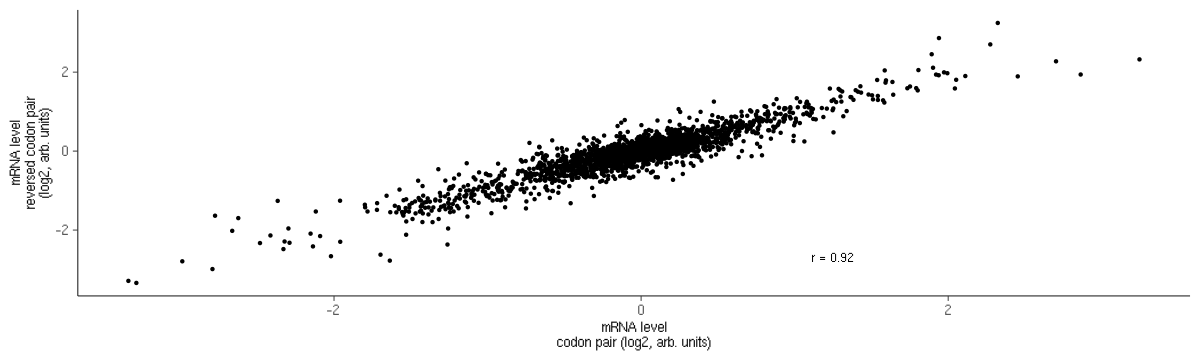

In [29]:
options(repr.plot.width = 10, repr.plot.height = 3)

plot_data %>% 
  ggplot(aes(y = lfc_2, x = frame0_lfc)) +
  geom_point(size = 0.2) +
  geom_text(aes(label = estimate), x = 2, y = -2.9, data = label_data, size=7/.pt) +
  theme + 
  theme(strip.background = element_blank(),
        strip.text.x = element_text(size = 8)) + 
  labs(x = "mRNA level\ncodon pair (log2, arb. units)", y = "mRNA level\nreversed codon pair\n(log2, arb. units)")

ggsave("../figures/wt_dicodon_frame_effects_rm_missing.pdf", width=1.8, height=1.7)

In [30]:
label_data

frame,n,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<chr>,<int>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>
+3,2534,r = 0.92,119.423,0,2532,0.9154477,0.9272044,Pearson's product-moment correlation,two.sided
